# Regression


## Task 1 

### Necessary imports

In [1]:
from typing import Callable, Dict, Tuple, List
import numpy as np
import sklearn.datasets as ds
from sklearn.preprocessing import MinMaxScaler
from scipy.optimize import minimize
import tracemalloc
import datetime
import matplotlib.pyplot as plt

### Regressors and functions definitions

In [2]:
def generate_dataset(samples: int =1000, attributes: int =1, noise: int =42) -> Tuple[np.ndarray, np.ndarray]:
    return ds.make_regression(n_samples=samples, n_features=attributes, noise=noise)

def normalize_data_set(train: np.ndarray, test: np.ndarray =None) -> Tuple[np.ndarray, np.ndarray]:
    scaler = MinMaxScaler()
    scaler.fit(train)
    return (scaler.transform(train), scaler.transform(test) if test is not None else None)

def benchmark(fun: Callable[[np.ndarray, np.ndarray], None], x: np.ndarray, y: np.ndarray, n: int =200) -> Dict[str, Dict[str,float]]:
    assert n > 0
    start = datetime.datetime.now()
    tracemalloc.start()

    [fun(x, y) for _ in range(n)]

    _ = tracemalloc.take_snapshot()
    current, peak = tracemalloc.get_traced_memory()
    mem = tracemalloc.get_tracemalloc_memory()
    tracemalloc.stop()
    diff = datetime.datetime.now() - start

    return {"memory": {"peak": peak, "mean": peak/n}, "time": {"total": diff.microseconds, "mean":diff.microseconds/n}}


class AnalyticLinearRegressor:
    
    def __init__(self) -> None:
        self.__theta: np.ndarray =None     
        self.__is_fit: bool =False

    def fit(self, train: np.ndarray, targets: np.ndarray) -> None:
        self.__is_fit = False
        broadcast_train = np.ones((train.shape[0], train.shape[1] + 1))
        broadcast_train[:, 1:] = train
        self.__theta = np.linalg.inv(broadcast_train.T @ broadcast_train) @ broadcast_train.T @ targets
        self.__is_fit = True

    def predict(self, sample: np.ndarray) -> np.ndarray:
        if not self.__is_fit:
            raise Exception("Model has not been fit yet!")
        broadcast_sample = np.ones((sample.shape[0], sample.shape[1] + 1))
        broadcast_sample[:, 1:] = sample
        return broadcast_sample @ self.__theta


class AnalyticRidgeRegressor:
    
    def __init__(self, reg_lambda: float) -> None:
        self.__theta: np.ndarray =None
        assert reg_lambda > 0
        self.__lambda = reg_lambda     
        self.__is_fit: bool =False

    def fit(self, train: np.ndarray, targets: np.ndarray) -> None:
        self.__is_fit = False
        broadcast_train = np.ones((train.shape[0], train.shape[1] + 1))
        broadcast_train[:, 1:] = train
        I = np.eye(broadcast_train.shape[1], broadcast_train.shape[1])
        self.__theta = np.linalg.inv((broadcast_train.T @ broadcast_train) + (self.__lambda * I)) @ broadcast_train.T @ targets
        self.__is_fit = True

    def predict(self, sample: np.ndarray) -> np.ndarray:
        if not self.__is_fit:
            raise Exception("Model has not been fit yet!")
        broadcast_sample = np.ones((sample.shape[0], sample.shape[1] + 1))
        broadcast_sample[:, 1:] = sample
        return broadcast_sample @ self.__theta


class NumericLinearRegressor:
    
    def __init__(self) -> None:
        self.__theta: np.ndarray =None     
        self.__is_fit: bool =False
        self.__is_fitting: bool =False

    def fit(self, train: np.ndarray, targets: np.ndarray) -> None:
        self.__is_fitting = True
        self.__is_fit = False
        N = targets.shape[0]
        _theta = np.ones(train.shape[1] + 1)

        def loss(__theta: np.ndarray) -> float:
            predicted: np.ndarray = self.__predict_batch(train, __theta)
            diff: np.ndarray = (targets - predicted)
            return (1/N) * (diff.T @ diff)

        self.__theta = minimize(fun=loss, x0=_theta, method='Powell').x
        self.__is_fit = True
        self.__is_fitting = False
    
    def __predict_batch(self, samples: np.ndarray, theta: np.ndarray =None) -> np.ndarray:
        if not (self.__is_fit or self.__is_fitting):
            raise Exception("Model has not been fit yet!")
        broadcast_samples = np.ones((samples.shape[0], samples.shape[1] + 1))
        if theta is None:
            theta = self.__theta
        broadcast_samples[:, 1:] = samples
        return broadcast_samples @ theta

    def predict(self, sample: np.ndarray) -> np.ndarray:
        if not (self.__is_fit or self.__is_fitting):
            raise Exception("Model has not been fit yet!")
        broadcast_sample = np.ones((sample.shape[0], sample.shape[1] + 1))
        broadcast_sample[:, 1:] = sample
        return broadcast_sample @ self.__theta

### Dataset generation

In [3]:
X, Y = generate_dataset(1012) #index No. 239512

### Benchmarking regressors

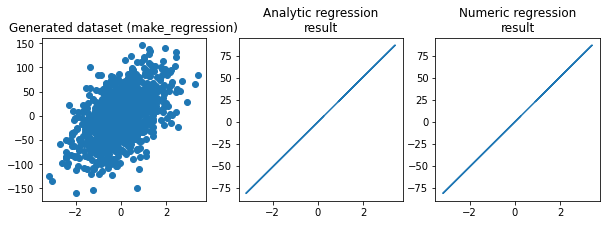

In [4]:
an_regressor = AnalyticLinearRegressor()
num_regressor = NumericLinearRegressor()
N = 1000

results_analytic = benchmark(lambda x,y: an_regressor.fit(x, y), X, Y, N)
results_numeric = benchmark(lambda x,y: num_regressor.fit(x, y), X, Y, N)
an_prediction = an_regressor.predict(X.reshape(-1,1))
num_prediction = num_regressor.predict(X.reshape(-1,1))

fig, axes = plt.subplots(1, 3, figsize=(10, 3))
axes[0].scatter(X, Y)
axes[0].set_title("Generated dataset (make_regression)")
axes[1].plot(X, an_prediction)
axes[1].set_title(f"Analytic regression\nresult")
axes[2].plot(X, num_prediction)
axes[2].set_title(f"Numeric regression\nresult")
plt.show()

### Plot results

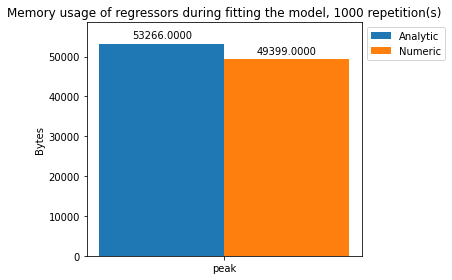

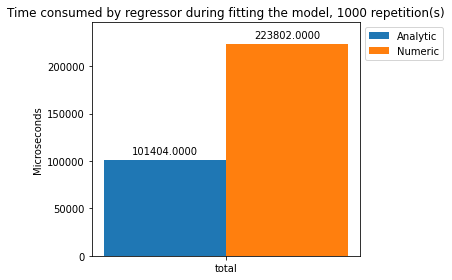

In [5]:

def res_plot(metrics: List[str], unit: str, title: str, analytic: List[float], numeric: List[float]):
    offset = np.arange(len(metrics))
    w=0.3
    fig, ax = plt.subplots()
    an_rec = ax.bar(offset, an, w, label="Analytic")
    nu_rec = ax.bar(offset + w, nu, w, label="Numeric")
    for h, r in zip(an, an_rec):
        ax.annotate(f'{h:.4f}',  xy=(r.get_x() + r.get_width() / 2, h), xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')
    for h, r in zip(nu, nu_rec):
        ax.annotate(f'{h:.4f}',  xy=(r.get_x() + r.get_width() / 2, h), xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')
    ax.set(ylabel=unit)
    ax.legend(loc='upper left', bbox_to_anchor=(1,1,1,0))
    ax.set_xticks(offset + w/2)
    ax.set_xticklabels(metrics)
    ax.set_title(title)
    fig.tight_layout()
    m = max(max(an), max(nu))
    plt.ylim(0.0,  1.1 * m)
    plt.show()

an = [results_analytic["memory"]["peak"]]
nu = [results_numeric["memory"]["peak"]]
title = f"Memory usage of regressors during fitting the model, {N} repetition(s)"
res_plot(["peak"], "Bytes", title, an, nu)

an = [results_analytic["time"]["total"]]
nu = [results_numeric["time"]["total"]]
title = f"Time consumed by regressor during fitting the model, {N} repetition(s)"
res_plot(["total"], "Microseconds", title, an, nu)


### Conclusions

* Analytic regressor consumed more memory in terms of reached peak, however it performs much faster, due to the fact that analytic regressor computes optimal theta vector in single operation, the numeric one tried to approximate optimal vector, hence it is a slow algorithm
* Both algorithms gave the same results of regression

## Task 2


### Additional imports

In [6]:
import csv
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import pandas as pd
from matplotlib.patches import Patch

### Load generated datasets
* first dataset contains 19 points, captured in neighbourhood of consecutive obstacles
* second dataset contains 117 points, captured during dodge obstacles maneuvers
* third dataset contains 1432 points, captured in the course of the whole game.  

In [7]:
test_x = np.arange(0.0, 6000.0, 1.0).reshape(-1, 1)
with open("task2_dataset_1.csv", 'r') as f:
    data_1 = csv.reader(f, csv.QUOTE_NONE)
    data_1 = np.array([[float(l[0]), float(l[1])] for l in data_1])
    data_1_x = data_1[:, 0].reshape(-1, 1)
    data_1_y = data_1[:, 1].reshape(-1, 1)
    norm_data_1_x, norm_data_1_test = normalize_data_set(data_1_x, test_x)

with open("task2_dataset_2.csv", 'r') as f:
    data_2 = csv.reader(f, csv.QUOTE_NONE)
    data_2 = np.array([[float(l[0]), float(l[1])] for l in data_2])
    data_2_x = data_2[:, 0].reshape(-1, 1)
    data_2_y = data_2[:, 1].reshape(-1, 1)
    norm_data_2_x, norm_data_2_test = normalize_data_set(data_2_x, test_x)

with open("task2_dataset_3.csv", 'r') as f:
    data_3 = csv.reader(f, csv.QUOTE_NONE)
    data_3 = np.array([[float(l[0]), float(l[1])] for l in data_3])
    data_3_x = data_3[:, 0].reshape(-1, 1)
    data_3_y = data_3[:, 1].reshape(-1, 1)
    norm_data_3_x, norm_data_3_test = normalize_data_set(data_3_x, test_x)

datasets = [(1, data_1_x, data_1_y, norm_data_1_x, norm_data_1_test), 
            (2, data_2_x, data_2_y, norm_data_2_x, norm_data_2_test), 
            (3, data_3_x, data_3_y, norm_data_3_x, norm_data_3_test)]

### Additional utilities

In [8]:
def dump_to_csv(path: str, X: np.ndarray, Y: np.ndarray):
    with open(path, 'w', newline='') as f:
        csv_file = csv.writer(f, csv.QUOTE_NONE, delimiter=';')
        for tup in zip(X,Y):
            csv_file.writerow(tup)
def mse(y_true: np.ndarray, y_pred: np.ndarray):
    return np.mean((y_true - y_pred)**2)

### Perform Linear Regression (using different polynomials) of FlapPyBird datasets

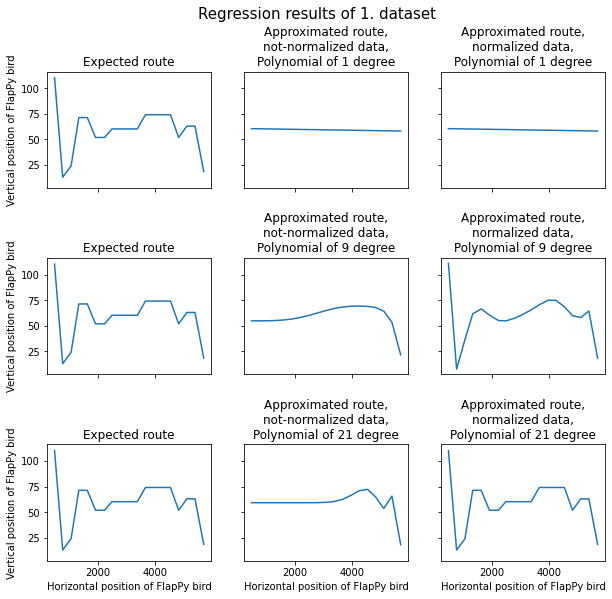

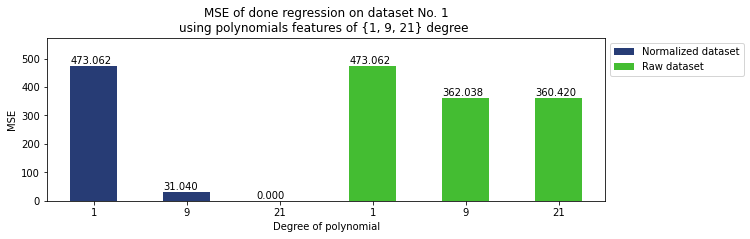

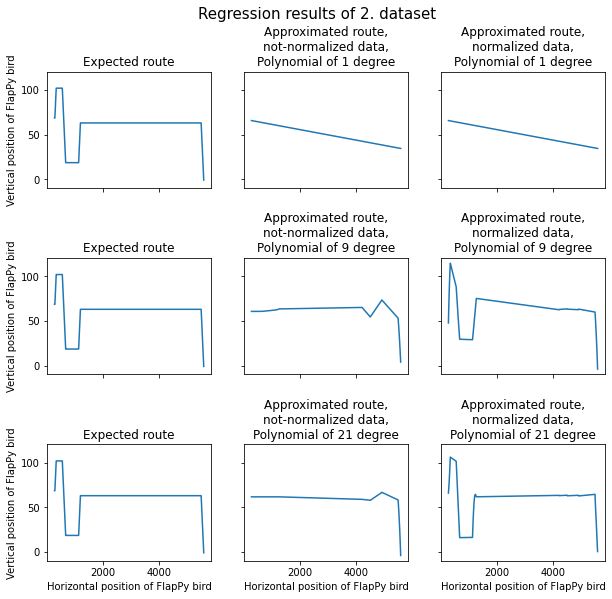

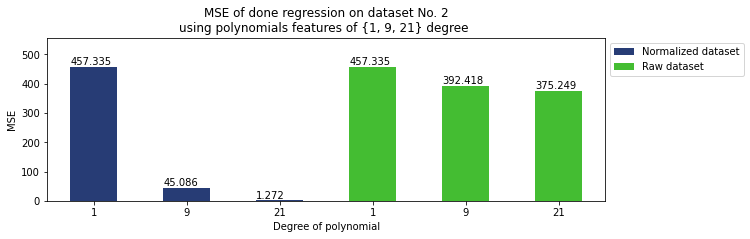

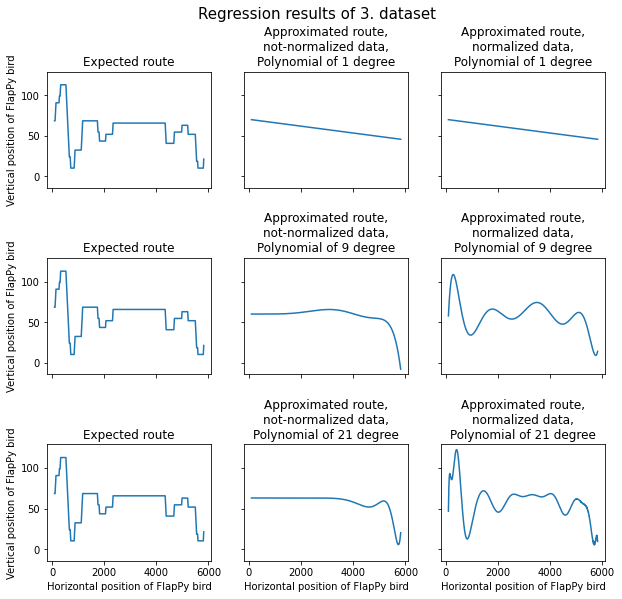

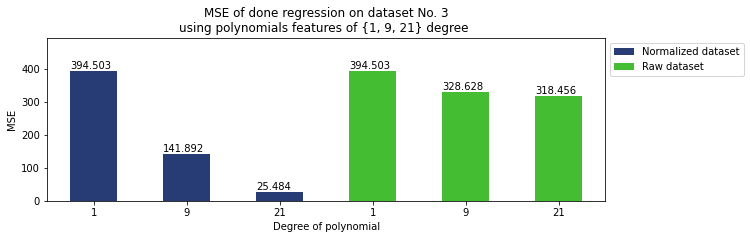

In [9]:
mse_s = {1:{"Normalized":{"degree":[], "MSE":[]}, "Not-normalized":{"degree":[], "MSE":[]}}, 
         2:{"Normalized":{"degree":[], "MSE":[]}, "Not-normalized":{"degree":[], "MSE":[]}}, 
         3:{"Normalized":{"degree":[], "MSE":[]}, "Not-normalized":{"degree":[], "MSE":[]}}}
for dataset in datasets:
    key, x, y, norm_x, norm_test = dataset
    fig, axes = plt.subplots(3, 3, figsize=(10,9),sharex=True, sharey=True)
    fig.suptitle(f"Regression results of {key}. dataset", fontsize=15)
    plt.setp(axes[-1, :], xlabel='Horizontal position of FlapPy bird')
    plt.setp(axes[:, 0], ylabel='Vertical position of FlapPy bird')
    for idx, i in enumerate([1, 9, 21]):
        model = make_pipeline(PolynomialFeatures(i), LinearRegression())
        model.fit(x, y)
        transformed = model.predict(x)
        test = model.predict(test_x)
        model.fit(norm_x, y)
        transformed_norm = model.predict(norm_x)
        test_norm = model.predict(norm_test)
        axes[idx,0].plot(x, y)
        axes[idx,0].set_title("Expected route")
        axes[idx,1].plot(x, transformed)
        axes[idx,1].set_title(f"Approximated route,\nnot-normalized data,\nPolynomial of {i} degree")
        axes[idx,2].plot(x, transformed_norm)
        axes[idx,2].set_title(f"Approximated route,\nnormalized data,\nPolynomial of {i} degree")
        mse_s[key]["Not-normalized"]["MSE"].append( mse(y, transformed))
        mse_s[key]["Not-normalized"]["degree"].append(i)        
        mse_s[key]["Normalized"]["MSE"].append( mse(y, transformed_norm))
        mse_s[key]["Normalized"]["degree"].append(i)
        dump_to_csv(f"task2_dataset_{key}_regression_result_poly_{i}_normalized.csv", test_x.flat, test_norm.flat)
        dump_to_csv(f"task2_dataset_{key}_regression_result_poly_{i}.csv", test_x.flat, test.flat)
    fig.subplots_adjust(hspace=0.6)
    plt.show()
    df = pd.concat([pd.DataFrame(d) for _, d in mse_s[key].items() ], keys=mse_s[key].keys()).droplevel(1)
    colours = {"Normalized": "#273c75", "Not-normalized": "#44bd32"}
    ax = df.plot.bar(x='degree', y='MSE', title=f"MSE of done regression on dataset No. {key}\nusing polynomials features of {{1, 9, 21}} degree ",
                     figsize=(10,3), rot=0, ylabel="MSE", xlabel="Degree of polynomial", color=df.reset_index()['index'].replace(colours))
    
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.3f}", (p.get_x(), p.get_height() + 8))
    ax.legend(
        [
            Patch(facecolor=colours['Normalized']),
            Patch(facecolor=colours['Not-normalized'])
        ], ["Normalized dataset", "Raw dataset"], loc='upper left', bbox_to_anchor=(1,1,1,0)
    )
    plt.ylim(top=df['MSE'].max()+100)
    plt.show()



### Conclusions

* Normalization of dataset is crucial in terms of obtained regression results - for normalized datasets, analyzed algorithms computed best curves.
* The greater degree of polynomial is used in linear regression, the better (the curve is closer to the expected one) results are produced.
* Obviously, the more points are in dataset, the higher degree of polynomial should be used to obtain better match between expected curve and computed one. 

## Task 3 - Ridge Regression

### Additional imports


In [10]:
from sklearn.linear_model import Ridge

### Comparison of sklearn Ridge regressor, custom analytic Ridge regressor and custom analytic linear regressor

#### Load of 9-points dataset, define comparison constants
* the dataset from FlapPyBird game was generated using --seed=239512 and it contains 9 points, captured in different stages of game.

In [11]:
regularization_parameters = [0.005, 0.01, 0.05, 0.1]
results = {}
normalized_results = {}
test_x = np.arange(0.0, 6000.0, 1.0).reshape(-1, 1)

with open("task3_dataset.csv", 'r') as f:
    data = csv.reader(f, csv.QUOTE_NONE)
    data = np.array([[float(l[0]), float(l[1])] for l in data])
    data_x = data[:, 0].reshape(-1, 1)
    data_y = data[:, 1].reshape(-1, 1)
    norm_data_x, norm_data_test = normalize_data_set(data_x, test_x)

#### Regression

In [12]:
results["Expected curve"] = data_y
normalized_results["Expected curve"] = data_y
for regularization_parameter in regularization_parameters:
    sk_ridge = make_pipeline(PolynomialFeatures(16), Ridge(alpha=regularization_parameter, solver='lsqr'))
    ridge = AnalyticRidgeRegressor(regularization_parameter)

    #raw dataset
    sk_ridge.fit(data_x, data_y)
    sk_result = sk_ridge.predict(data_x)
    results[f"sklearn Ridge regressor,\nalpha={regularization_parameter}, raw data"] = sk_result
    ridge.fit(data_x, data_y)
    ridge_result = ridge.predict(data_x)
    results[f"Custom analytic Ridge regressor,\nlambda={regularization_parameter}, raw data"] = ridge_result
    
    #normalized dataset
    sk_ridge.fit(data_x, data_y)
    sk_result_norm = sk_ridge.predict(norm_data_x)
    normalized_results[f"sklearn Ridge regressor,\nalpha={regularization_parameter}, normalized data"] = sk_result_norm
    ridge.fit(norm_data_x, data_y)
    ridge_result_norm = ridge.predict(norm_data_x)
    normalized_results[f"Custom analytic Ridge regressor,\nlambda={regularization_parameter}, normalized data"] = ridge_result_norm

lin_reg = AnalyticLinearRegressor()
#raw dataset
lin_reg.fit(data_x, data_y)
lin_reg_result = lin_reg.predict(data_x)
results[f"Custom analytic linear\nregressor, raw data"] = lin_reg_result
#normalized dataset
lin_reg.fit(norm_data_x, data_y)
lin_reg_result_norm = lin_reg.predict(norm_data_x)
normalized_results[f"Custom analytic linear\nregressor, normalized data"] = lin_reg_result_norm



#### Results

In [13]:
def display_plots_and_mse_table(results, data_x, data_y):
    fig,axes = plt.subplots(2,5, figsize=(20,6), sharex=True, sharey=True)
    plt.setp(axes[-1, :], xlabel='Horizontal position of FlapPy bird')
    plt.setp(axes[:, 0], ylabel='Vertical position of FlapPy bird')

    fig.suptitle("The comparison of sklearn implementation of Ridge regression (polynomial of 16 degree), custom analytic Ridge regression and analytic linear regression",y=1, fontsize='x-large')
    for item, ax in zip(results.items(), axes.flat):
        k,v = item
        ax.plot(data_x, v)
        ax.set_title(k)
    plt.ylim(top=max(data_y)+20, bottom=0)
    fig.subplots_adjust(hspace=0.8)

    plt.show()
    mse_s_1 = {k:mse(data_y, v) for k, v in results.items() if k != "Expected curve"}

    fig, ax = plt.subplots(figsize=(10, 10))
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')
    ax.set_title("The table of MSE values\nof analyzed algorithms", fontsize=30)
    t = ax.table(cellText=[[f"{t:.3f}"] for t in mse_s_1.values()], colLabels=['MSE'],colWidths= [1], rowLabels=list(mse_s_1.keys()), loc='upper center')
    t.set_fontsize(14)
    t.scale(1, 4)
    fig.tight_layout()

    plt.show()

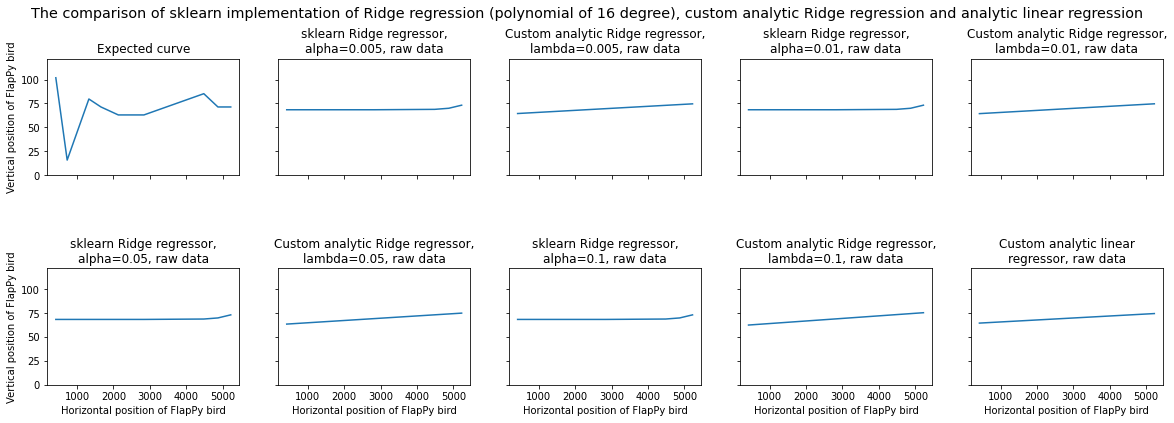

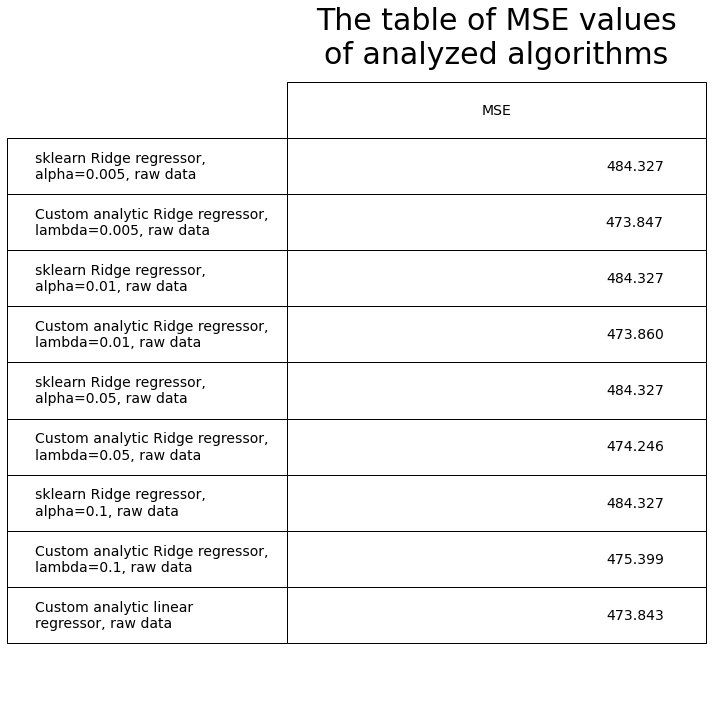

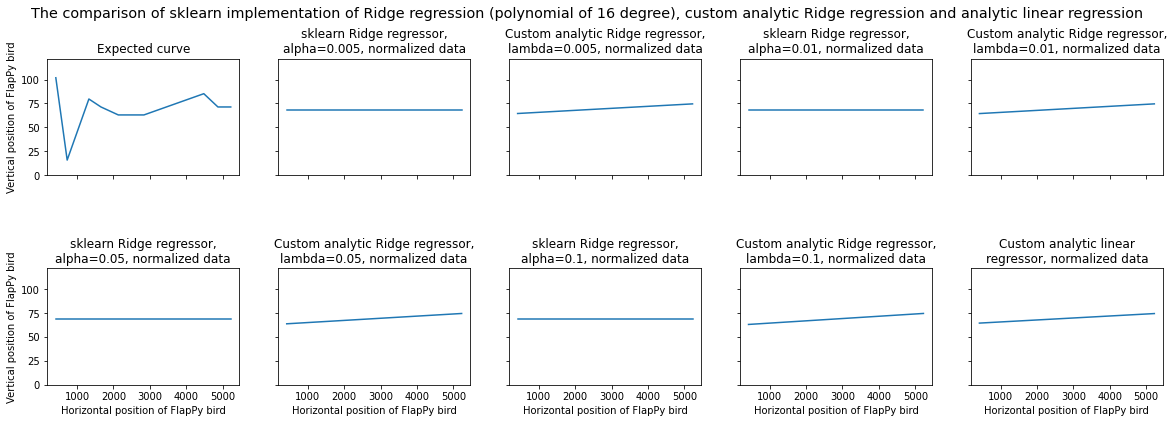

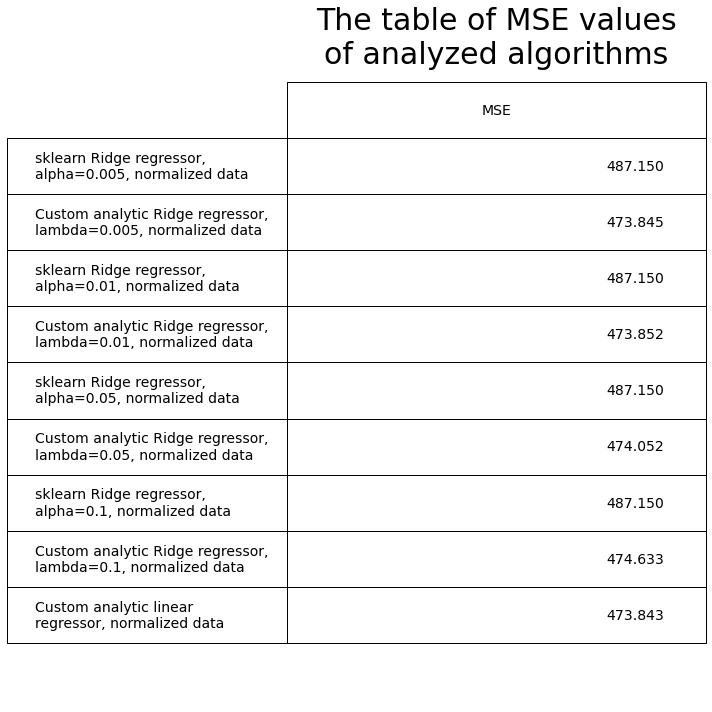

In [14]:
display_plots_and_mse_table(results, data_x, data_y)
display_plots_and_mse_table(normalized_results, data_x, data_y)

### Conclusions
* for the analyzed specific case of generated dataset from game FlapPyBird, obtained results are hard to interpret, however, it can be noticed, that analytic regressors produced better results in terms of MSE, than Ridge regressor from sklearn package - with applied 16th degree polynomial features.
* what is hard to understand, is the observation, that sklearn implementation seems to ignore alpha - the regularization parameter. Maybe it is related to the initialization routine and to this specific case - for this dataset, sklearn package refused to use anything, in terms of solver, but 'lsqr', hence I initialized the algorithm with the latter.